In [1]:
import glob
import os
import codecs
import numpy as np
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForTokenClassification
from tqdm.notebook import tqdm

c:\users\amina\appdata\local\programs\python\python38\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
def read_articles_from_file_list(folder_name, file_pattern="*.txt"):
    '''
    Read articles from files matching patterns <file_pattern> from  
    the directory <folder_name>. 
    The content of the article is saved in the dictionary whose key
    is the id of the article (extracted from the file name).
    Each element of <sentence_list> is one line of the article.
    '''
    file_list = glob.glob(os.path.join(folder_name, file_pattern))
    articles = {}
    article_id_list, sentence_id_list, sentence_list = ([], [], [])
    for filename in sorted(file_list):
        article_id = os.path.basename(filename).split('.')[0][7:]
        with codecs.open(filename, 'r', encoding='utf8') as f:
            articles[article_id] = f.read()
    return articles

def read_predictions_from_file(filename):
    '''
    Reader for the gold file and the template output file. 
    Return values are four arrays with article ids, labels 
    (or ? in the case of a template file), begin of a fragment, 
    end of a fragment. 
    '''
    articles_id, span_starts, span_ends, gold_labels = ([], [], [], [])
    with open(filename, 'r') as f:
        for row in f.readlines():
            article_id, gold_label, span_start, span_end = row.rstrip().split('\t')
            articles_id.append(article_id)
            gold_labels.append((gold_label, int(span_start), int(span_end)))
    return articles_id, gold_labels

In [45]:
def label(text, gt_labels):
    tokens = []
    labels = []
    special_symbols = """!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~ \n\t\'\\"""
    sentence = []
    sent_labels = []
    word = ''
    inside = False
    word_start = 0
    for i in range(len(text)):
        if text[i] in special_symbols:
            if len(word) > 1:
                sentence.append(word)
                word = ''
                if inside:
                    sent_labels.append(1)
                else:
                    sent_labels.append(0)
                # if the sentence has ended
                if text[i] in "!.?\n" and (i < len(text) - 2 and not (text[i+1].islower() or text[i+2].islower())):
                    if len(sentence) > 1:
                        tokens.append(sentence)
                        labels.append(sent_labels)
                        sentence = []
                        sent_labels = []
        else:
            if len(word) == 0:
                word_start = i
            word += text[i]
        if len(gt_labels) > 0:
            if i == gt_labels[0][1]:
                inside = True
            elif i == gt_labels[0][2] + 1:
                inside = False
                gt_labels.pop(0)
    return tokens, labels
    

def create_dataset(path_to_articles, path_to_labels):
    '''
    Creates the dataset from the files contained in 'datasets/train-articles/' folder
    
    texts : list, each represents one article and contains
    '''
    texts = []
    labels = []
    articles = read_articles_from_file_list(path_to_articles)
    article_names = list(articles.keys())
    prefix_lbl = path_to_labels + '/article'
    postfix_lbl = '.task-flc-tc.labels'
    for name in article_names:
        articles_id, gold_labels = read_predictions_from_file(prefix_lbl + name + postfix_lbl)
        gt_labels = []
        for i in range(len(gold_labels)):
            if gold_labels[i][0] == 'Loaded_Language':
                gt_labels.append(gold_labels[i])
        gt_labels.sort(key=lambda x: x[1])
        tokens, lbls = label(articles[name], gt_labels)
        texts.extend(tokens)
        labels.extend(lbls)
    
    return texts, labels, article_names

In [46]:
path_to_articles = 'datasets/train-articles'
path_to_labels = 'datasets/train-labels-task-flc-tc'
texts, labels, article_names = create_dataset(path_to_articles, path_to_labels)

In [47]:
print(len(texts))
print(len(labels))

15881
15881


In [48]:
len(texts[432]) == len(labels[432])

True

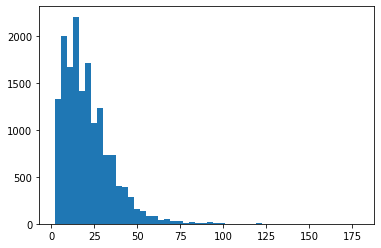

In [49]:
lengths = [len(x) for x in texts]
plt.hist(lengths, bins=50)
plt.show()

In [50]:
max(lengths)

179

In [51]:
texts[:10]

[['Next',
  'plague',
  'outbreak',
  'in',
  'Madagascar',
  'could',
  'be',
  'stronger',
  'WHO'],
 ['Geneva',
  'The',
  'World',
  'Health',
  'Organisation',
  'chief',
  'on',
  'Wednesday',
  'said',
  'adeadly',
  'plague',
  'epidemic',
  'appeared',
  'to',
  'have',
  'been',
  'brought',
  'under',
  'control',
  'in',
  'Madagascar',
  'but',
  'warned',
  'the',
  'next',
  'outbreak',
  'would',
  'likely',
  'be',
  'stronger'],
 ['The',
  'next',
  'transmission',
  'could',
  'be',
  'more',
  'pronounced',
  'or',
  'stronger',
  'WHO',
  'Director',
  'General',
  'Tedros',
  'Adhanom',
  'Ghebreyesus',
  'told',
  'reporters',
  'in',
  'Geneva',
  'insisting',
  'that',
  'the',
  'issue',
  'is',
  'serious'],
 ['An',
  'outbreak',
  'of',
  'both',
  'bubonic',
  'plague',
  'which',
  'is',
  'spread',
  'by',
  'infected',
  'rats',
  'via',
  'flea',
  'bites',
  'and',
  'pneumonic',
  'plague',
  'spread',
  'person',
  'to',
  'person',
  'has',
  'kille